<a href="https://colab.research.google.com/github/Fournierp/alfred/blob/streamlit/models/LSTM%20Percent%20Change.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Stock Market Data

In this kernel, we will design and train the model we will use in our web app. We will develop a Long Short-Term Memory (LSTM) Neural Network and harness its capability to solve problems in time series. This model will take as input closing stock prices percent change with previous closing prices and predict the next days stock prices percent change.

Most resources online showed how to train a LSTM model on a single company's historical stock market dataset. Yet I want a model I can use to predict prices for various companies on the Alfred web-app. So I will aggregate a lot of data on publicly traded companies and train a model that can capture live stock market patterns.

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf

import pandas as pd
import numpy as np

import datetime
import json

import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, HoverTool
from bokeh.plotting import figure, output_notebook, show, save

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow.keras.backend as K

In [3]:
np.random.seed(512)


# Pre-Processing

In [4]:
# Get the same list of companies that can be studied on Alfred
companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S'
                         '%26P_500_companies')[0]
# For the sake of the Proof Of Concept, we will use fewer companies than that
companies = companies[['Symbol']][companies['GICS Sector'] == 'Information Technology'].values.flatten()

In [5]:
# Select a random company for evaluation
index = int(np.random.random()*len(companies))
eval_company = companies[index]
companies = np.delete(companies, index)
eval_company

'AMAT'

The first challenge posed to us is to format the data. The LSTM needs a window of historical data points and a window of target points. This function splits the data accordingly

In [6]:
# Shape the data into strips of historical prices for the LSTM
input_len = 30
output_len = 1

def split_percent_change_in_windows(df):
    """
    Create series of "input_len" Closing prices (X) and its coresponding "output_len" price (Y).  
    """
    LSTM_inputs = []
    LSTM_outputs = []
    for i in range(input_len, len(df)-1):
        # Process the model's input sequence
        initial = df[i-input_len : i].copy()
        final   = df[i-input_len+1: i+1].copy()
        historical_percent_change = (final - initial) / initial
        LSTM_inputs.append(np.array(historical_percent_change))
        
        # Process the model's expected output sequence
        target_price = (df[i+1] - df[i]) / df[i]  
        LSTM_outputs.append(np.array(target_price))
        
    LSTM_inputs = np.array(LSTM_inputs)
    LSTM_outputs = np.array(LSTM_outputs)
    
    return LSTM_inputs, LSTM_outputs

Let's download all this data and store it in an array.

In [7]:
# We will manually create the arrays with the first company before looping for the rest
cmp = yf.download(companies[0])
# Get the closing price into a train and test array
train_set = cmp.iloc[:int(cmp.shape[0]*.80), 3:4].values
test_set = cmp.iloc[int(cmp.shape[0]*.80):, 3:4].values
# Get the closing price into format acceptable for the LSTM
x_train, y_train = split_percent_change_in_windows(train_set)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
x_test, y_test = split_percent_change_in_windows(test_set)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

for company in companies[1:]:
    cmp = yf.download(company)
    # Get the closing price into a train and test array
    train_set_tmp = cmp.iloc[:int(cmp.shape[0]*.80), 3:4].values
    test_set_tmp = cmp.iloc[int(cmp.shape[0]*.80):, 3:4].values
    # Get the closing price into format acceptable for the LSTM
    x_train_tmp, y_train_tmp = split_percent_change_in_windows(train_set)
    x_train_tmp = np.reshape(x_train_tmp, (x_train_tmp.shape[0], x_train_tmp.shape[1]))
    x_test_tmp, y_test_tmp = split_percent_change_in_windows(test_set)
    x_test_tmp = np.reshape(x_test_tmp, (x_test_tmp.shape[0], x_test_tmp.shape[1]))
    # Gather the data points into a single array
    x_train = np.concatenate((x_train, x_train_tmp))
    x_test = np.concatenate((x_test, x_test_tmp))
    y_train = np.concatenate((y_train, y_train_tmp))
    y_test = np.concatenate((y_test, y_test_tmp))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Now that we have numerous company's historical stock market data, let us process it to facilitate the learning of the LSTM. Given the different scales of the companies, their stocks have different values. Let's scale the data according to the MinMaxScaler: normalize the data between (0, 1) based on the the overall maximum and minimum prices of all companies.

In [8]:
# Shuffle the train data to avoid bias due to the ordering of data.
x_train, y_train = shuffle(x_train, y_train)

In [9]:
# Reshape the data for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Model Design

In [10]:
class LossHistory(Callback):
    def __init__(self):
        self.loss = []
        self.val_loss = []

    def on_batch_end(self, epoch, logs={}):
        self.loss.append(logs.get('loss'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss.append(logs.get('val_loss'))

In [11]:
def LSTM_model(input_shape, output_shape, neurons, dropout):
    x = Input(shape=input_shape)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=True)(x)
    hidden = Dropout(dropout)(hidden)
    hidden = LSTM(neurons, return_sequences=False)(hidden)
    hidden = Dropout(dropout)(hidden)
    y = Dense(output_shape, activation='linear')(hidden)
    return Model(inputs=x, outputs=y)

model = LSTM_model((input_len, 1), output_len, 50, 0.2)

optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(optimizer=optimizer, metrics=['mse'], loss = 'mean_squared_error')

In [12]:
# Baseline
model.evaluate(x_test, y_test)

2204/2204 [==============================] - 9s 3ms/step - loss: 2.8196e-04 - mse: 2.8196e-04


[0.000286304421024397, 0.000286304421024397]

In [13]:
epoch_size = 100
batch_size = 32

# Callback function to graph losses
lh = LossHistory()

# Callback function to stopp when the validation loss stagnates
es = EarlyStopping(patience=3)

# Training

In [14]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test),
          epochs = epoch_size, batch_size = batch_size, callbacks=[lh, es])

Epoch 1/100
9026/9026 [==============================] - 62s 7ms/step - loss: 3.8838e-04 - mse: 3.8838e-04 - val_loss: 2.8315e-04 - val_mse: 2.8315e-04
Epoch 2/100
9026/9026 [==============================] - 59s 6ms/step - loss: 3.8786e-04 - mse: 3.8786e-04 - val_loss: 2.8304e-04 - val_mse: 2.8304e-04
Epoch 3/100
9026/9026 [==============================] - 59s 6ms/step - loss: 3.8755e-04 - mse: 3.8755e-04 - val_loss: 2.8274e-04 - val_mse: 2.8274e-04
Epoch 4/100
9026/9026 [==============================] - 58s 6ms/step - loss: 3.8743e-04 - mse: 3.8743e-04 - val_loss: 2.8242e-04 - val_mse: 2.8242e-04
Epoch 5/100
9026/9026 [==============================] - 58s 6ms/step - loss: 3.8725e-04 - mse: 3.8725e-04 - val_loss: 2.8304e-04 - val_mse: 2.8304e-04
Epoch 6/100
9026/9026 [==============================] - 59s 7ms/step - loss: 3.8705e-04 - mse: 3.8705e-04 - val_loss: 2.8290e-04 - val_mse: 2.8290e-04
Epoch 7/100
9026/9026 [==============================] - 58s 6ms/step - loss: 3.8696e-04

# Evaluation

In [15]:
model.evaluate(x_test, y_test)

2204/2204 [==============================] - 7s 3ms/step - loss: 2.8268e-04 - mse: 2.8268e-04


[0.00028267857851460576, 0.00028267857851460576]

Text(0.5, 0, 'Epoch')

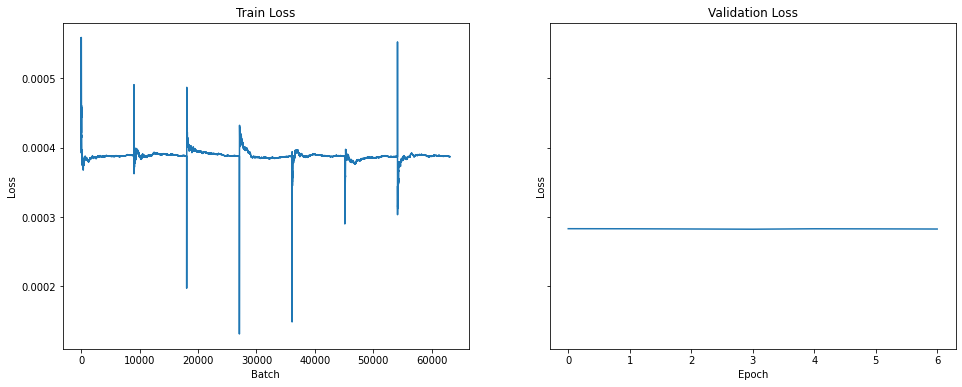

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ax1.plot(lh.loss)
ax1.set_title('Train Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Batch')
ax2.plot(lh.val_loss)
ax2.set_title('Validation Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

## Evaluate on unseen stock

In [17]:
df = yf.download(eval_company)
df.index.name = None
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
1980-03-17,0.000000,0.098090,0.095486,0.095486,0.072228,3600000
1980-03-18,0.000000,0.096354,0.093750,0.093750,0.070915,3715200
1980-03-19,0.000000,0.098090,0.095486,0.095486,0.072228,2016000
1980-03-20,0.000000,0.099826,0.097222,0.097222,0.073541,3657600
1980-03-21,0.000000,0.103299,0.100694,0.100694,0.076167,3024000
...,...,...,...,...,...,...
2021-01-29,100.230003,100.459999,96.070000,96.680000,96.680000,7933800
2021-02-01,99.250000,102.150002,97.680000,101.209999,101.209999,9083600
2021-02-02,102.989998,103.940002,101.769997,103.589996,103.589996,5108600
2021-02-03,104.320000,104.410004,99.820000,99.870003,99.870003,5395900


In [18]:
eval_set = df.iloc[:, 3:4].values

x_eval, y_eval = split_percent_change_in_windows(eval_set)
x_eval = np.reshape(x_eval, (x_eval.shape[0], x_eval.shape[1], 1))

In [19]:
# Inverse transform: make the percent price change prediction into an actual closing price
predicted_stock_price_change = model.predict(x_eval)#* (total_max - total_min) + total_min
predicted_stock_price_change = np.reshape(predicted_stock_price_change,
                                          (predicted_stock_price_change.shape[0]))
last_closing_price = np.reshape(eval_set[input_len+1:], (eval_set[input_len+1:].shape[0]))
predicted_stock_price = last_closing_price * (1 + predicted_stock_price_change)

In [20]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()

In [21]:
df1 = pd.DataFrame(eval_set, index=df.iloc[:, 3:4].index, columns=["Close"])
df2 = pd.DataFrame(predicted_stock_price, index= df.iloc[input_len+1:, 3:4].index, columns=["Close"])
df1["Date"] = pd.to_datetime(df1.index)
df2["Date"] = pd.to_datetime(df2.index)
dates1 = df1['Date']
dates2 = df2['Date']
source1 = ColumnDataSource(data=dict(date=dates1, close=df1['Close']))
source2 = ColumnDataSource(data=dict(date=dates2, close=df2['Close']))

p = figure(plot_height=300, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates1[dates1.index[-100]], dates1[dates1.index[-1]]))
tmp = p.x_range # Store it before adding multiple lines
p.line('date', 'close', source=source1, legend_label='Real Stock Price', color='green')
p.line('date', 'close', source=source2, legend_label='Predicted Stock Price', color='blue')

p.yaxis.axis_label = 'Price'


hover_tool = HoverTool(
    tooltips=[
        ( 'date',   '@date{%F}'            ),
        ( 'close',  '$@{close}{%0.2f}' ), # use @{ } for field names with spaces
    ],

    formatters={
        '@date'        : 'datetime', # use 'datetime' formatter for '@date' field
        '@{close}' : 'printf',   # use 'printf' formatter for '@{adj close}' field
                                     # use default 'numeral' formatter for other fields
    },

    # display a tooltip whenever the cursor is vertically in line with a glyph
    # mode='vline'
)
p.add_tools(hover_tool)

TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range, tools=TOOLS, 
                x_axis_type="datetime", y_axis_type=None,
                toolbar_location=None, background_fill_color="#efefef")

range_tool = RangeTool(x_range=tmp)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source1)
select.ygrid.grid_line_color = None
select.add_tools(range_tool, hover_tool)
select.toolbar.active_multi = range_tool

# output_notebook()
# show(column(p, select))
# save(column(p, select), filename="plots/lstm_next_price.html")
bokeh.plotting.show(column(p, select))

In [22]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
# Save the model.
# serialize model to JSON
model_json = model.to_json()
with open("lstm_percent_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("lstm_percent.h5")

In [25]:
%cp lstm_percent.h5 /content/gdrive/My\ Drive
%cp lstm_percent_model.json /content/gdrive/My\ Drive

# Conclusion

This experiment showed interesting results. The model predicts small percent price changes which means the predicted curve fits very well the actuall curve but also suggests the model learns nothing and dummily predicts 0% price change.

